### Federated Learning of the simple CNN model as **FL-DeepCovid** using fedAvg

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2024-06-05 10:13:10.393548: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 10:13:10.423733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 10:13:10.423759: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 10:13:10.423776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 10:13:10.429583: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [ ]:
import pandas as pd
import random
import cv2
#from keras.utils.vis_utils import plot_model
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
#import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
import logging
tf.config.set_visible_devices([], 'GPU')
from sklearn import preprocessing

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from tqdm.notebook import tqdm
import time

#import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
import time
import numpy as np
IMAGE_SIZE = 200

### Functions to Evaluate Models after Training

In [ ]:
import seaborn as sns
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'

def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()

    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__,
                    predicted_labels=predictions)

## Data Source

Hopital 1 (Datasets 1), Hospital 2 (Dataset2 2) and Hospital 3 (Datasets 3)

- https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images (dataset3)
- https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/ (dataset3)

- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset (dataset2)

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans (Dataset1)
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset (Dataset1)

####  Loading NumPy Array Datasets:

In [ ]:
# # # Load the array from the file
input_data_x_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_input.npy')
output_label_y_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_output.npy')
input_data_x_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_input.npy')
output_label_y_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_output.npy')
input_data_x_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_input.npy')#.astype('float64')
output_label_y_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_output.npy')
#input_data_x_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_input.npy')
#output_label_y_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_output.npy')

#Now loaded_arr contains the array loaded from the file
print('------------------ DATASET 1 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_load.shape))

print('------------------ DATASET 2 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_2_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_2_load.shape))

print('------------------ DATASET 3 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_3_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_3_load.shape))

# print('------------------ DATASET 4 ---------------------')
# print('Input_x Data Shape: \n{0}'.format(input_data_x_4_load.shape))
# print('Output_y Data Shape: \n{0}'.format(output_label_y_4_load.shape))

------------------ DATASET 1 ---------------------
Input_x Data Shape: 
(4649, 200, 200, 1)
Output_y Data Shape: 
(4649, 2)
------------------ DATASET 2 ---------------------
Input_x Data Shape: 
(14486, 200, 200, 1)
Output_y Data Shape: 
(14486, 2)
------------------ DATASET 3 ---------------------
Input_x Data Shape: 
(2540, 200, 200, 1)
Output_y Data Shape: 
(2540, 2)


##### Data used to train teacher models for each client

In [ ]:
from sklearn.model_selection import train_test_split


train_features_dataset1, test_features_dataset1, train_labels_dataset1, test_labels_dataset1 = train_test_split(
    input_data_x_load[0:2500,:], output_label_y_load[0:2500,:], test_size=.20, random_state=25)

train_features_dataset2, test_features_dataset2, train_labels_dataset2, test_labels_dataset2 = train_test_split(
    input_data_x_2_load[0:6500,:], output_label_y_2_load[0:6500,:], test_size=.20, random_state=25)

train_features_dataset3, test_features_dataset3, train_labels_dataset3, test_labels_dataset3 = train_test_split(
    input_data_x_3_load[0:1200,:], output_label_y_3_load[0:1200,:], test_size=.20, random_state=25)

print('------ Training Teacher Models----------')
print('client 1 teacher dataset: ',train_features_dataset1.shape, test_features_dataset1.shape, train_labels_dataset1.shape, test_labels_dataset1.shape)
print('client 2 teacher dataset: ',train_features_dataset2.shape, test_features_dataset2.shape, train_labels_dataset2.shape, test_labels_dataset2.shape)
print('client 3 teacher dataset: ',train_features_dataset3.shape, test_features_dataset3.shape, train_labels_dataset3.shape, test_labels_dataset3.shape)

------ Training Teacher Models----------
client 1 teacher dataset:  (2000, 200, 200, 1) (500, 200, 200, 1) (2000, 2) (500, 2)
client 2 teacher dataset:  (5200, 200, 200, 1) (1300, 200, 200, 1) (5200, 2) (1300, 2)
client 3 teacher dataset:  (960, 200, 200, 1) (240, 200, 200, 1) (960, 2) (240, 2)


## Federated Learning Datasets

In [ ]:
def dataset_pixel_stat(dataset):
    mean_pixel_value = np.mean(dataset)
    variance_pixel_value = np.var(dataset)
    std_dev_pixel_value = np.std(dataset)
    # Display the computed statistics
    print("Mean Pixel Value:", mean_pixel_value)
    print("Variance of Pixel Values:", variance_pixel_value)
    print("Standard Deviation of Pixel Values:", std_dev_pixel_value)

    # Compute histograms of pixel values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dataset.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Pixel Values (Entire Dataset)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Assuming you have subsets 'subset1' and 'subset2' of the dataset
    # Compute histograms for each subset
    plt.subplot(1, 2, 2)
    plt.hist(dataset[0:500,:].flatten(), bins=50, color='red', alpha=0.7, label='Subset 1')
    plt.hist(dataset[501:1000,:].flatten(), bins=50, color='green', alpha=0.7, label='Subset 2')
    plt.hist(dataset[1001:1500,:].flatten(), bins=50, color='yellow', alpha=0.7, label='Subset 3')

    plt.title('Histogram of Pixel Values (Subsets)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

In [ ]:
print('------ Federated Training----------')
train_features_dataset1_fed, test_features_dataset1_fed, train_labels_dataset1_fed, test_labels_dataset1_fed = train_test_split(
    input_data_x_load[2501:3901,:], output_label_y_load[2501:3901,:], test_size=.20, random_state=25)
train_features_dataset2_fed, test_features_dataset2_fed, train_labels_dataset2_fed, test_labels_dataset2_fed = train_test_split(
    input_data_x_2_load[6501:10400,:], output_label_y_2_load[6501:10400,:], test_size=.20, random_state=25)
train_features_dataset3_fed, test_features_dataset3_fed, train_labels_dataset3_fed, test_labels_dataset3_fed = train_test_split(
    input_data_x_3_load[1201:,:], output_label_y_3_load[1201:,:], test_size=.20, random_state=25)
print('client 1 federated dataset: ', train_features_dataset1_fed.shape, test_features_dataset1_fed.shape, train_labels_dataset1_fed.shape, test_labels_dataset1_fed.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed.shape, test_features_dataset2_fed.shape, train_labels_dataset2_fed.shape, test_labels_dataset2_fed.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed.shape, test_features_dataset3_fed.shape, train_labels_dataset3_fed.shape, test_labels_dataset3_fed.shape)


------ Federated Training----------
client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


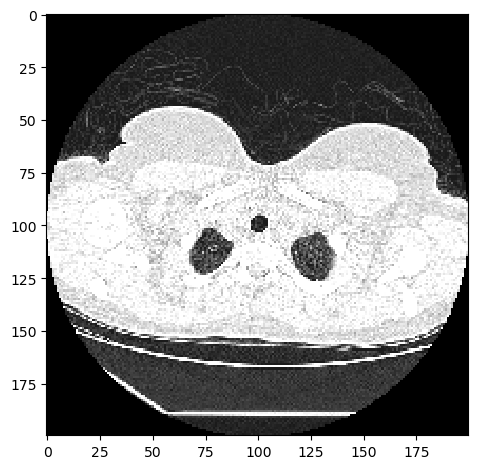

---------------Client 2 sample Image -----------------


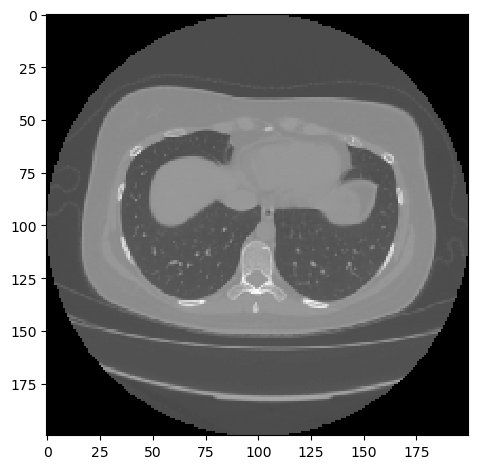

---------------Client 3 sample Image -----------------


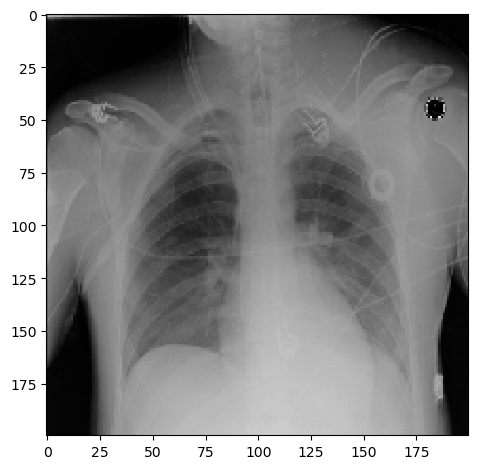

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed[0])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed[100])
show()

In [ ]:
print('--------------------- Testing dataset--------------')
# Assuming client_images and client_labels are numpy arrays or lists of numpy arrays
X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
                                  test_features_dataset3_fed), axis=0)
y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
                                  test_labels_dataset3_fed), axis=0)

--------------------- Testing dataset--------------


### Preparing The Federated Dataset (non_iid Dataset )

Mean Pixel Value: 0.5149437324054628
Variance of Pixel Values: 0.13384306055452233
Standard Deviation of Pixel Values: 0.36584567860577816


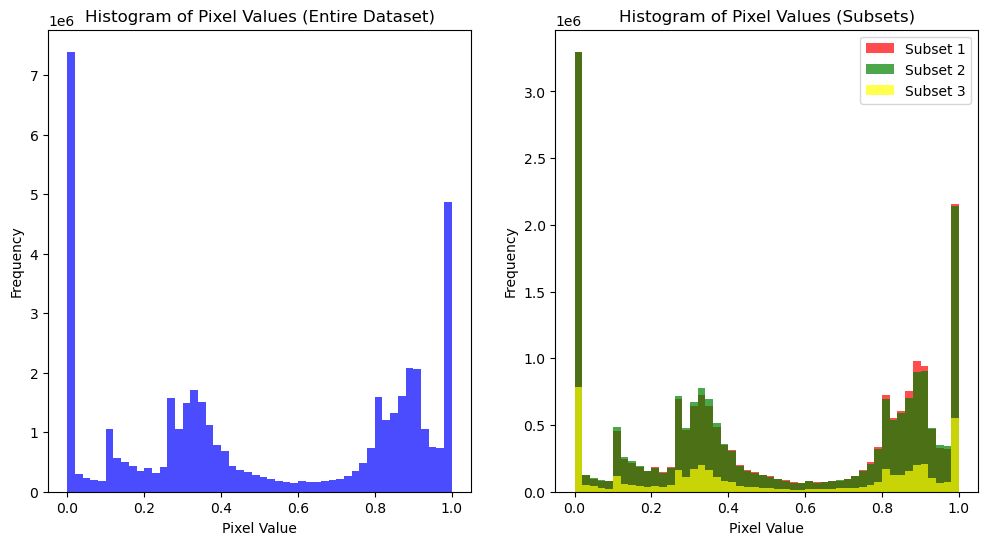

Mean Pixel Value: 0.2761424951121855
Variance of Pixel Values: 0.056925370933381306
Standard Deviation of Pixel Values: 0.23859038315359926


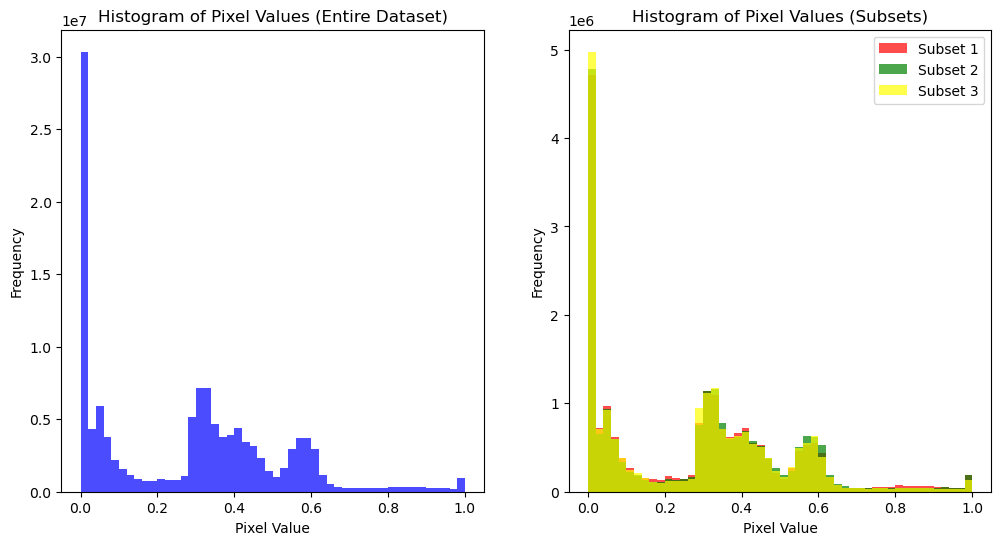

Mean Pixel Value: 0.5393774509803901
Variance of Pixel Values: 0.07674632723644069
Standard Deviation of Pixel Values: 0.2770312748345224


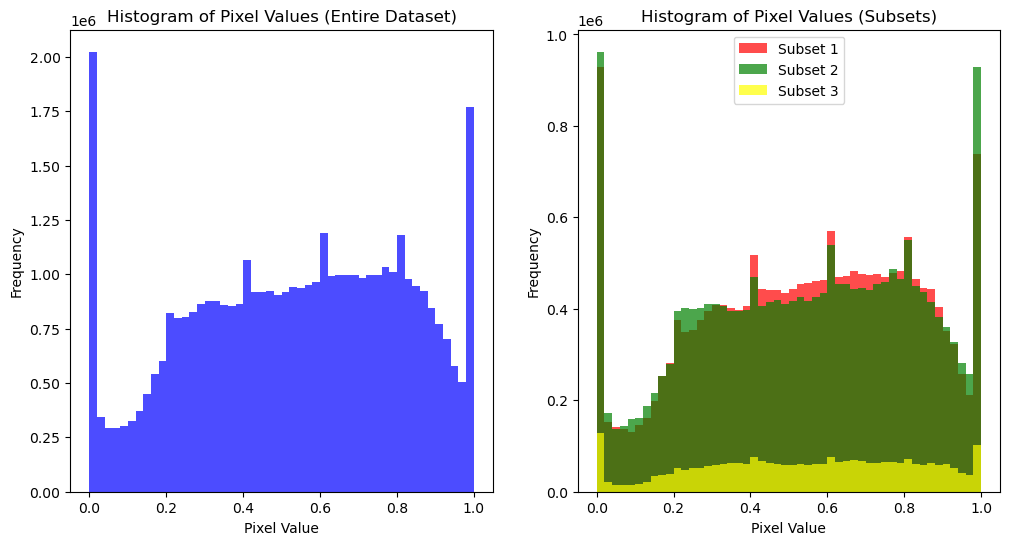

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed)
dataset_pixel_stat(train_features_dataset2_fed)
dataset_pixel_stat(train_features_dataset3_fed)

###### non-iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed, train_labels_dataset2_fed),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]#(train_features_dataset3_fed, train_labels_dataset3_fed)

NUM_CLIENTS = len(client_data)  # Number of clients
BATCH_SIZE = 20

def create_tf_dataset_for_client(client_dataset):
    """Create a tf.data.Dataset object for a client's data."""
    client_images, client_labels = client_dataset
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    return dataset

client_datasets = [create_tf_dataset_for_client(data) for data in client_data]

def preprocess_dataset(dataset, batch_size=BATCH_SIZE , shuffle_buffer_size=100):
    """Preprocess the dataset."""
    return dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
#federated_clients
fed_clients = ['client_'+str(i) for i in range(1,NUM_CLIENTS+1)]

# Federated data preparation
federated_train_data_nonIID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid Unbalanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid Unbalanced Dataset Data type:  <class 'list'>
Length:  3


###### non-iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed[0:1200,:], train_labels_dataset2_fed[0:1200,:]),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_nonIID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid balanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Preparing The Federated Dataset (iid Dataset )

In [ ]:
train_features_dataset1_fed_iid, test_features_dataset1_fed_iid, train_labels_dataset1_fed_iid, test_labels_dataset1_fed_iid = train_test_split(
    input_data_x_2_load[6501:7901,:], output_label_y_2_load[6501:7901,:], test_size=.20, random_state=42)
train_features_dataset2_fed_iid, test_features_dataset2_fed_iid, train_labels_dataset2_fed_iid, test_labels_dataset2_fed_iid = train_test_split(
    input_data_x_2_load[7901:11800,:], output_label_y_2_load[7901:11800,:], test_size=.20, random_state=42)
train_features_dataset3_fed_iid, test_features_dataset3_fed_iid, train_labels_dataset3_fed_iid, test_labels_dataset3_fed_iid = train_test_split(
    input_data_x_2_load[11800:13139,:], output_label_y_2_load[11800:13139,:], test_size=.20, random_state=42)
print('client 1 federated dataset: ', train_features_dataset1_fed_iid.shape, test_features_dataset1_fed_iid.shape, train_labels_dataset1_fed_iid.shape, test_labels_dataset1_fed_iid.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed_iid.shape, test_features_dataset2_fed_iid.shape, train_labels_dataset2_fed_iid.shape, test_labels_dataset2_fed_iid.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed_iid.shape, test_features_dataset3_fed_iid.shape, train_labels_dataset3_fed_iid.shape, test_labels_dataset3_fed_iid.shape)

client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


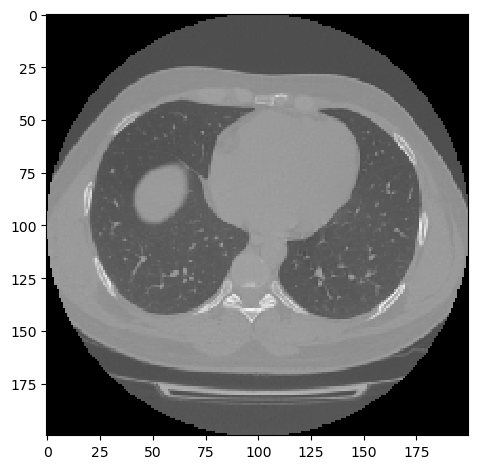

---------------Client 2 sample Image -----------------


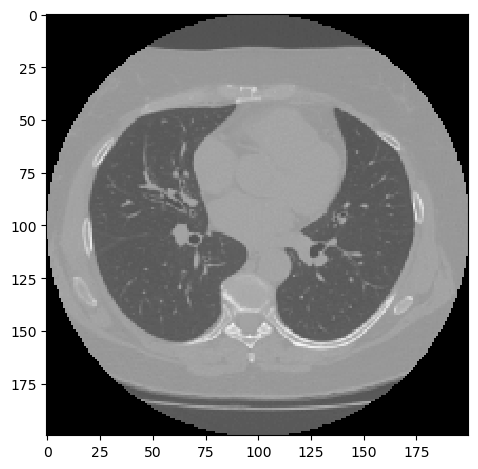

---------------Client 3 sample Image -----------------


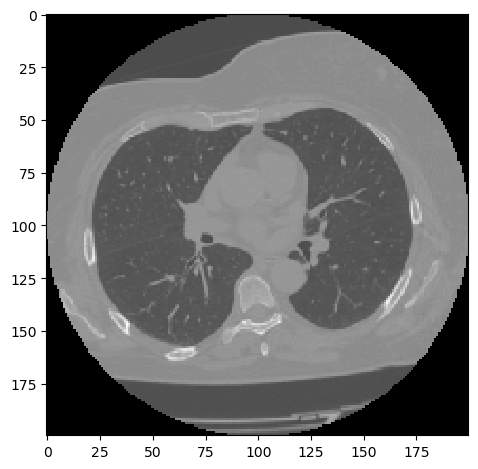

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed_iid[100])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed_iid[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed_iid[0])
show()

Mean Pixel Value: 0.27787371095938374
Variance of Pixel Values: 0.0582723553891214
Standard Deviation of Pixel Values: 0.24139667642517657


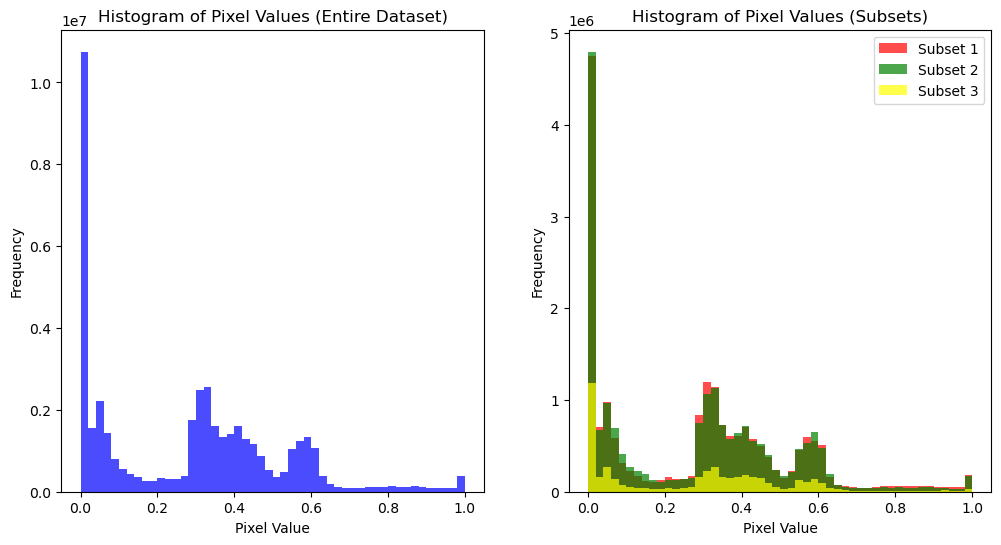

Mean Pixel Value: 0.27760929562014075
Variance of Pixel Values: 0.056485812467578035
Standard Deviation of Pixel Values: 0.2376674409076221


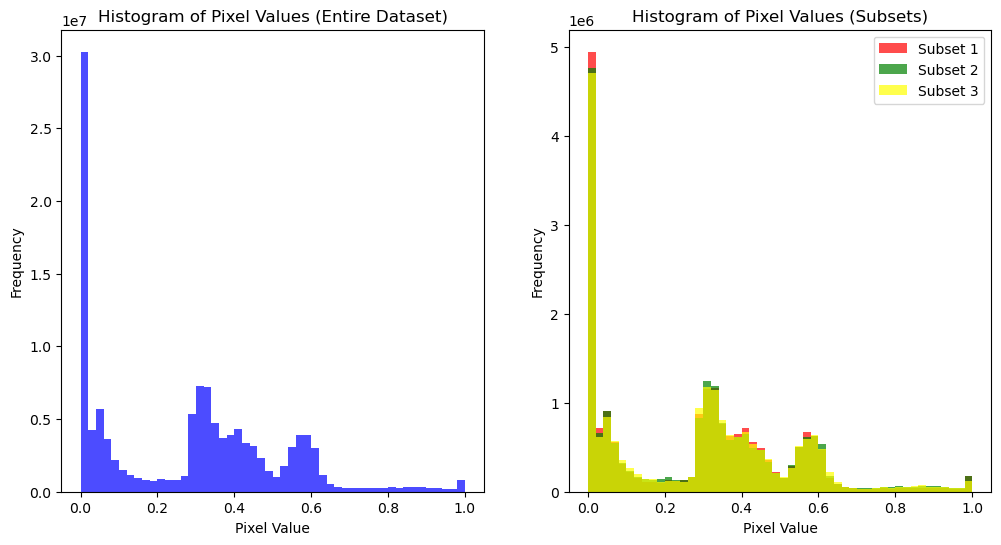

Mean Pixel Value: 0.2768275683345227
Variance of Pixel Values: 0.05673954491991269
Standard Deviation of Pixel Values: 0.23820064004933464


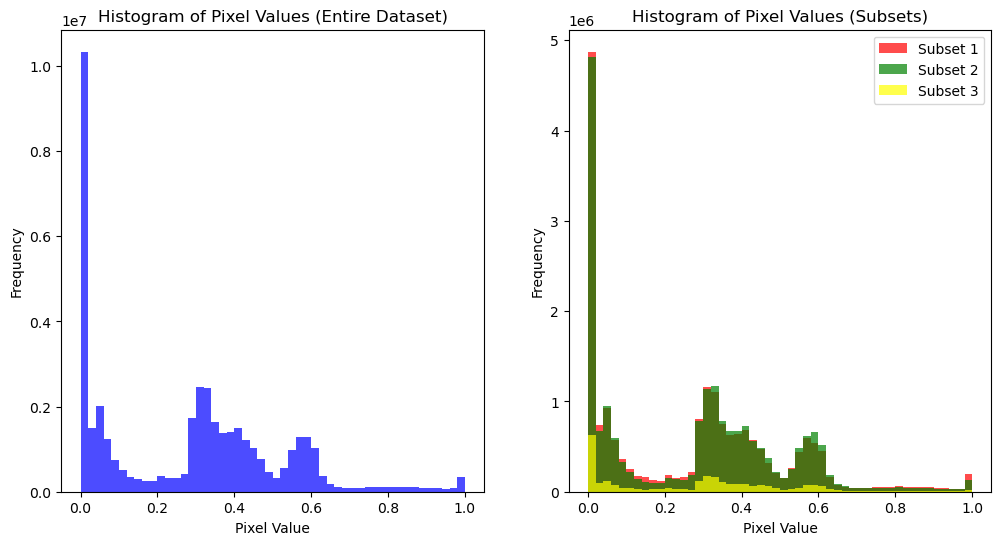

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed_iid)
dataset_pixel_stat(train_features_dataset2_fed_iid)
dataset_pixel_stat(train_features_dataset3_fed_iid)

###### iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid, train_labels_dataset2_fed_iid),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid unbalanced Dataset Data type: ', type(federated_train_data_IID_unbalanced))
print('Length: ', len(federated_train_data_IID_unbalanced))

Fedrated iid unbalanced Dataset Data type:  <class 'list'>
Length:  3


In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid[0:1200,:], train_labels_dataset2_fed_iid[0:1200,:]),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid balanced Dataset Data type: ', type(federated_train_data_IID_balanced))
print('Length: ', len(federated_train_data_IID_balanced))

Fedrated iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Federated Learning

In [ ]:
'''
##### Training Teacher Model (Deep-COVID)
M. Ghaderzadeh, F. Asadi, R. Jafari, D. Bashash, H. Abolghasemi, and M. Aria. Deep
convolutional neural network–based computer-aided detection system for covid-19 using mul-
tiple lung scans: Design and implementation study. J Med Internet Res, 23:e27468, 2021,4.
http://www.ncbi.nlm.nih.gov/pubmed/33848973
'''

SEED = 7
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

from tensorflow.keras.applications import NASNetLarge
NETWORK = NASNetLarge

#from kaggle_datasets import KaggleDatasets

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report


import re
import imageio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print("Tensorflow version ", tf.__version__)

from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

image_size = 200
img_augmentation = keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="Augmentation",
)
#img_augmentation.layers[0].adapt(train_features_dataset2)

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

# dataset_id1 = 'covid19-lung-ct-scans'
# #GCS_PATH1 = KaggleDatasets().get_gcs_path(dataset_id1)
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

CLASSES = ['COVID-19', 'Non-COVID-19']
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE_ = [IMAGE_SIZE, IMAGE_SIZE]#224, 224
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)#224, 224, 3
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

METRICS = ['accuracy']

Epochs = 50
Early_Stop = 15
OPTIMIZER = tensorflow.keras.optimizers.legacy.Adam(lr = 1e-2, decay = 1e-4)

Fine_Tune_Epochs = 100
Fine_Tune_Early_Stop = 20
Fine_Tune_OPTIMIZER = tensorflow.keras.optimizers.legacy.Adam(lr = 1e-3, decay = 1e-6)
Fine_Tune_filepath = "Best-Model-FT.h5"

Callbacks = [
    CosineAnnealingScheduler(Epochs, 1e-3, 1e-6),
    EarlyStopping(monitor='val_accuracy', patience=Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

FT_Callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=2, mode='min', min_delta=0.0001, cooldown=1, min_lr=1e-6),
    ModelCheckpoint(Fine_Tune_filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor='val_loss', patience=Fine_Tune_Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

from tensorflow.keras.layers import Lambda
input_tensor = Input(shape=input_shape)
input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)



Number of replicas: 1
Tensorflow version  2.14.0


/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#DeepCovid Architecture
def create_DeepCovid_model(OPTIMIZER, LOSS, METRICS):
    input_tensor = Input(shape=input_shape)
    input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)
    model = None
    inputs = layers.Input(shape=input_shape)
    x = inputs#img_augmentation(inputs)
    baseModel = keras.applications.NASNetLarge(
    #input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=input_rgb,
    pooling='avg',
    classifier_activation="softmax",
)
    #baseModel = NETWORK(include_top=False, input_tensor=x, weights="imagenet", pooling ='avg')

    baseModel.trainable = False

    x = BatchNormalization(axis = -1, name="Batch-Normalization-1")(baseModel.output)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-2")(x)
    x = Dropout(.2, name="Dropout-1")(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-3")(x)

    outputs = Dense(NUM_CLASSES, activation="softmax", name="Classifier")(x)
    model = tf.keras.Model(inputs=baseModel.input, outputs=outputs, name="Deep-COVID")

    #model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

    return model

#DEEO-COVID Teacher Model wrapping as TFF model
def model_fn(initial_weights=None):
    keras_model = create_DeepCovid_model(OPTIMIZER, LOSS, METRICS)
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_nonIID_unbalanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
    """Performs local training on the client's dataset."""
    # Initialize the client model with the current server weights.
    client_weights = model.trainable_variables
    # Assign the server weights to the client model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)
    # Initialize the client optimizer.
    trainable_tensor_specs = tf.nest.map_structure(
          lambda v: tf.TensorSpec(v.shape, v.dtype), client_weights)
    optimizer_state = client_optimizer.initialize(trainable_tensor_specs)
    # Use the client_optimizer to update the local model.
    for batch in iter(dataset):
        with tf.GradientTape() as tape:
            # Compute a forward pass on the batch of data.
            outputs = model.forward_pass(batch)
        # Compute the corresponding gradient.
        grads = tape.gradient(outputs.loss, client_weights)
        # Apply the gradient using a client optimizer.
        optimizer_state, updated_weights = client_optimizer.next(
            optimizer_state, client_weights, grads)
        tf.nest.map_structure(lambda a, b: a.assign(b),
                              client_weights, updated_weights)
    # Return model deltas.
    return tf.nest.map_structure(tf.subtract, client_weights, server_weights)

In [ ]:
import attrs
from typing import Any
import functools
@attrs.define(eq=False, frozen=True)
class ServerState(object):
    trainable_weights: Any
    optimizer_state: Any

@tf.function
def server_update(server_state, mean_model_delta, server_optimizer):
    """Updates the server model weights."""
    # Use aggregated negative model delta as pseudo gradient.
    negative_weights_delta = tf.nest.map_structure(
      lambda w: -1.0 * w, mean_model_delta)
    new_optimizer_state, updated_weights = server_optimizer.next(
      server_state.optimizer_state, server_state.trainable_weights,
      negative_weights_delta)
    return tff.structure.update_struct(
      server_state,
      trainable_weights=updated_weights,
      optimizer_state=new_optimizer_state)

In [ ]:
#1. Server and client optimizer to be used.
server_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.05, momentum=0.8)
client_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.01)

In [ ]:
# 2. Functions return initial state on server.
@tff.tf_computation
def server_init():
    model = model_fn()
    trainable_tensor_specs = tf.nest.map_structure(
        lambda v: tf.TensorSpec(v.shape, v.dtype), model.trainable_variables)
    optimizer_state = server_optimizer.initialize(trainable_tensor_specs)
    return ServerState(
      trainable_weights=model.trainable_variables,
      optimizer_state=optimizer_state)
@tff.federated_computation
def server_init_tff():
    return tff.federated_value(server_init(), tff.SERVER)

/tmp/ipykernel_230469/591050228.py:3: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  def server_init():
2024-06-05 10:46:52.889549: W tensorflow/c/c_api.cc:305] Operation '{name:'reduction_A_block_stem_2/block_1/separable_conv_block_reduction_right1_stem_2/separable_conv_2_reduction_right1_stem_2/depthwise_kernel/Assign' id:1393 op device:{requested: '', assigned: ''} def:{{{node reduction_A_block_stem_2/block_1/separable_conv_block_reduction_right1_stem_2/separable_conv_2_reduction_right1_stem_2/depthwise_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](reduction_A_block_stem_2/block_1/separable_conv_block_reduction_right1_stem_2/separable_conv_2_reduction_right1_stem_2/depthwise_kernel, reduction_A_block_stem_2/block_1/separable_conv_block_reduction_right1_stem_2/separable_conv_2_reduction_right1_stem_2/depthwise_kernel/Initializer/stateless_random_uniform)}}' was chang

In [ ]:
# 3. One round of computation and communication.
server_state_type = server_init.type_signature.result
print('server_state_type:\n',
      server_state_type.formatted_representation())
trainable_weights_type = server_state_type.trainable_weights
print('trainable_weights_type:\n',
      trainable_weights_type.formatted_representation())

server_state_type:
 <
  trainable_weights=<
    float32[4032],
    float32[4032],
    float32[4032,512],
    float32[512],
    float32[512],
    float32[512],
    float32[512,256],
    float32[256],
    float32[256],
    float32[256],
    float32[256,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[4032],
      float32[4032],
      float32[4032,512],
      float32[512],
      float32[512],
      float32[512],
      float32[512,256],
      float32[256],
      float32[256],
      float32[256],
      float32[256,2],
      float32[2]
    >
  >
>
trainable_weights_type:
 <
  float32[4032],
  float32[4032],
  float32[4032,512],
  float32[512],
  float32[512],
  float32[512],
  float32[512,256],
  float32[256],
  float32[256],
  float32[256],
  float32[256,2],
  float32[2]
>


In [ ]:
# 3-1. Wrap server and client TF blocks with `tff.tf_computation`.
@tff.tf_computation(server_state_type, trainable_weights_type)
def server_update_fn(server_state, model_delta):
    return server_update(server_state, model_delta, server_optimizer)

/tmp/ipykernel_230469/2044740559.py:2: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(server_state_type, trainable_weights_type)


In [ ]:
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(tff.types.tensorflow_to_type(whimsy_model.input_spec))
print('tf_dataset_type:\n',
      tf_dataset_type.formatted_representation())

@tff.tf_computation(tf_dataset_type, trainable_weights_type)
def client_update_fn(dataset, server_weights):
    model = model_fn()
    return client_update(model, dataset, server_weights, client_optimizer)

tf_dataset_type:
 <
  float64[?,200,200,1],
  uint8[?,2]
>*


/tmp/ipykernel_230469/3793503675.py:6: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(tf_dataset_type, trainable_weights_type)
2024-06-05 10:48:30.166675: W tensorflow/c/c_api.cc:305] Operation '{name:'normal_A_block_1/block_2/separable_conv_block_normal_right2_1/separable_conv_2_normal_right2_1/pointwise_kernel/Assign' id:3691 op device:{requested: '', assigned: ''} def:{{{node normal_A_block_1/block_2/separable_conv_block_normal_right2_1/separable_conv_2_normal_right2_1/pointwise_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](normal_A_block_1/block_2/separable_conv_block_normal_right2_1/separable_conv_2_normal_right2_1/pointwise_kernel, normal_A_block_1/block_2/separable_conv_block_normal_right2_1/separable_conv_2_normal_right2_1/pointwise_kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session

In [ ]:
# 3-2. Orchestration with `tff.federated_computation`.
federated_server_type = tff.FederatedType(server_state_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
@tff.federated_computation(federated_server_type, federated_dataset_type)
def run_one_round(server_state, federated_dataset):
    # Server-to-client broadcast.
    server_weights_at_client = tff.federated_broadcast(
      server_state.trainable_weights)
    # Local client update.
    model_deltas = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
    # Client-to-server upload and aggregation.
    mean_model_delta = tff.federated_mean(model_deltas)
    # Server update.
    server_state = tff.federated_map(
      server_update_fn, (server_state, mean_model_delta))
    return server_state

In [ ]:
# 4. Build the iterative process for FedAvg.
fedavg_process = tff.templates.IterativeProcess(
    initialize_fn=server_init_tff, next_fn=run_one_round)
print('type signature of `initialize`:\n',
      fedavg_process.initialize.type_signature.formatted_representation())
print('type signature of `next`:\n',
      fedavg_process.next.type_signature.formatted_representation())

type signature of `initialize`:
 ( -> <
  trainable_weights=<
    float32[4032],
    float32[4032],
    float32[4032,512],
    float32[512],
    float32[512],
    float32[512],
    float32[512,256],
    float32[256],
    float32[256],
    float32[256],
    float32[256,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[4032],
      float32[4032],
      float32[4032,512],
      float32[512],
      float32[512],
      float32[512],
      float32[512,256],
      float32[256],
      float32[256],
      float32[256],
      float32[256,2],
      float32[2]
    >
  >
>@SERVER)
type signature of `next`:
 (<
  server_state=<
    trainable_weights=<
      float32[4032],
      float32[4032],
      float32[4032,512],
      float32[512],
      float32[512],
      float32[512],
      float32[512,256],
      float32[256],
      float32[256],
      float32[256],
      float32[256,2],
      float32[2]
    >,
    optimizer_state=<


### Evaluating the algorithm

https://www.tensorflow.org/federated/tutorials/custom_federated_algorithm_with_tff_optimizers#evaluating_the_algorithm

In [ ]:
def map_function(input_data, target_data):
    # Apply any necessary transformations to input_data and target_data here
    # For example, you can cast the target_data to a different dtype if needed
    target_data = tf.cast(target_data, tf.float32)
    return input_data, target_data

test_data = [(X_test_combined,y_test_combined )]
test_datasets = [create_tf_dataset_for_client(data) for data in test_data]
combined_test_data = [preprocess_dataset(dataset) for dataset in test_datasets]
combined_test_data = combined_test_data[0].map(map_function)

In [ ]:
def evaluate(server_state, dataset):
    keras_model = create_DeepCovid_model(OPTIMIZER, LOSS, METRICS)
    #student_model = tf.keras.models.load_model('student_CNN_model.h5')
    #model_student_weight = student_model.get_weights()
    #keras_model.set_weights(model_student_weight)
    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    #keras_model.set_weights(server_state.trainable_weights)
    for var, new_weight in zip(keras_model.trainable_variables, server_state.trainable_weights):
        var.assign(new_weight)
    keras_model.evaluate(dataset)
    return keras_model

server_state = fedavg_process.initialize()
student_inital_model = evaluate(server_state, combined_test_data)

2024-06-05 10:48:54.076513: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-05 10:48:54.076614: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-05 10:48:54.080362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14826 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-05 10:48:54.080569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14826 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-05 10:48:54.080768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14826 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:67:00.0, compute c

67/67 [==============================] - 33s 445ms/step - loss: 1.1901 - categorical_accuracy: 0.4616


9/9 [==============================] - 9s 687ms/step


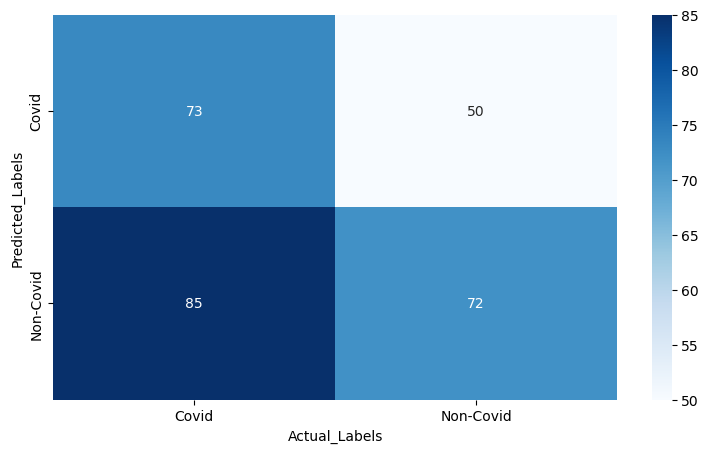

test accuracy = 51.78571428571429%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5179
Precision: 0.5347
Recall: 0.5179
F1 Score: 0.5181
25/25 [==============================] - 17s 694ms/step


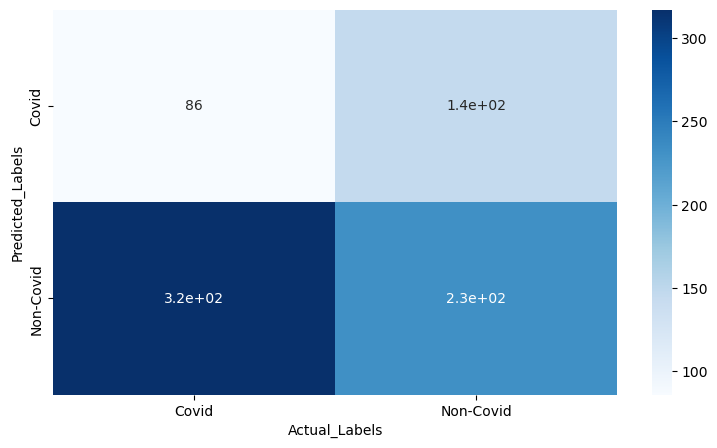

test accuracy = 40.76923076923077%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4077
Precision: 0.3966
Recall: 0.4077
F1 Score: 0.3824
9/9 [==============================] - 6s 658ms/step


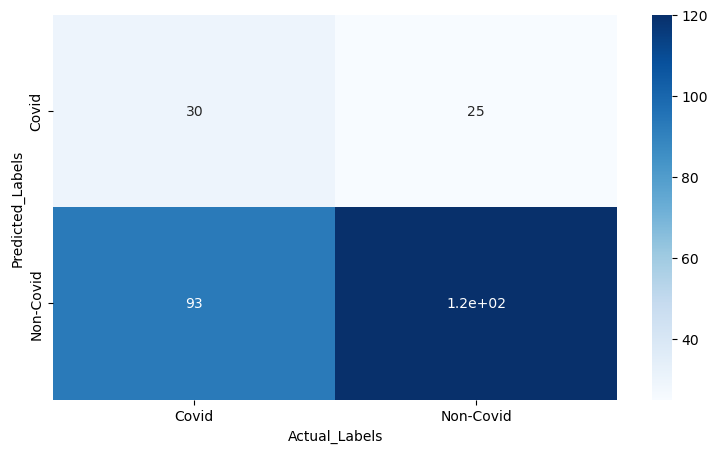

test accuracy = 55.970149253731336%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5597
Precision: 0.5552
Recall: 0.5597
F1 Score: 0.5174


In [ ]:
# X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
#                                   test_features_dataset3_fed), axis=0)
# y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
#                                   test_labels_dataset3_fed), axis=0)
getModelEvaluation(student_inital_model,test_features_dataset1_fed,test_labels_dataset1_fed)
getModelEvaluation(student_inital_model,test_features_dataset2_fed,test_labels_dataset2_fed)
getModelEvaluation(student_inital_model,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
metrics = {'loss':[],'accuracy':[]}

## FedAvg StudentMod_only Experiments

- federated_train_data_nonIID_unbalanced
- federated_train_data_nonIID_balanced
- federated_train_data_IID_unbalanced
- federated_train_data_IID_balanced

### federated_train_data_nonIID_unbalanced

In [ ]:
from tqdm import tqdm
import time
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_unbalanced)
    FL_DeepCovid_model = evaluate(server_state,combined_test_data)
    loss = list(FL_DeepCovid_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_DeepCovid_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]2024-06-05 10:50:11.770122: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-06-05 10:50:11.770213: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-05 10:50:11.773868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14826 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-06-05 10:50:11.774077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14826 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-06-05 10:50:11.774276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14826 MB m

67/67 [==============================] - 33s 450ms/step - loss: 1.1878 - categorical_accuracy: 0.4654


  2%|▊                                        | 1/50 [04:54<4:00:36, 294.62s/it]

67/67 [==============================] - 36s 438ms/step - loss: 1.1839 - categorical_accuracy: 0.4661


  4%|█▋                                       | 2/50 [08:16<3:12:08, 240.17s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1796 - categorical_accuracy: 0.4714


  6%|██▍                                      | 3/50 [11:31<2:52:02, 219.63s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1764 - categorical_accuracy: 0.4812


  8%|███▎                                     | 4/50 [14:46<2:40:57, 209.95s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1744 - categorical_accuracy: 0.4917


 10%|████                                     | 5/50 [18:01<2:33:18, 204.41s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1737 - categorical_accuracy: 0.5060


 12%|████▉                                    | 6/50 [21:16<2:27:31, 201.18s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1739 - categorical_accuracy: 0.5060


 14%|█████▋                                   | 7/50 [24:35<2:23:37, 200.40s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1752 - categorical_accuracy: 0.5120


 16%|██████▌                                  | 8/50 [27:50<2:19:04, 198.68s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1766 - categorical_accuracy: 0.5151


 18%|███████▍                                 | 9/50 [31:05<2:15:01, 197.61s/it]

67/67 [==============================] - 32s 435ms/step - loss: 1.1780 - categorical_accuracy: 0.5226


 20%|████████                                | 10/50 [34:20<2:11:07, 196.69s/it]

67/67 [==============================] - 32s 436ms/step - loss: 1.1796 - categorical_accuracy: 0.5248


 22%|████████▊                               | 11/50 [37:35<2:07:39, 196.39s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1811 - categorical_accuracy: 0.5279


 24%|█████████▌                              | 12/50 [40:58<2:05:33, 198.25s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1827 - categorical_accuracy: 0.5241


 26%|██████████▍                             | 13/50 [44:17<2:02:25, 198.53s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1840 - categorical_accuracy: 0.5248


 28%|███████████▏                            | 14/50 [47:36<1:59:12, 198.68s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1853 - categorical_accuracy: 0.5264


 30%|████████████                            | 15/50 [50:52<1:55:23, 197.83s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1860 - categorical_accuracy: 0.5218


 32%|████████████▊                           | 16/50 [54:07<1:51:36, 196.96s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1868 - categorical_accuracy: 0.5181


 34%|█████████████▌                          | 17/50 [57:29<1:49:13, 198.59s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1882 - categorical_accuracy: 0.5181


 36%|█████████████▋                        | 18/50 [1:00:45<1:45:25, 197.68s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1889 - categorical_accuracy: 0.5158


 38%|██████████████▍                       | 19/50 [1:04:04<1:42:24, 198.20s/it]

67/67 [==============================] - 33s 447ms/step - loss: 1.1899 - categorical_accuracy: 0.5158


 40%|███████████████▏                      | 20/50 [1:07:22<1:39:02, 198.08s/it]

67/67 [==============================] - 33s 449ms/step - loss: 1.1907 - categorical_accuracy: 0.5166


 42%|███████████████▉                      | 21/50 [1:10:42<1:36:00, 198.62s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1912 - categorical_accuracy: 0.5158


 44%|████████████████▋                     | 22/50 [1:14:00<1:32:36, 198.45s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1911 - categorical_accuracy: 0.5151


 46%|█████████████████▍                    | 23/50 [1:17:20<1:29:28, 198.82s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1903 - categorical_accuracy: 0.5143


 48%|██████████████████▏                   | 24/50 [1:20:39<1:26:12, 198.96s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1892 - categorical_accuracy: 0.5158


 50%|███████████████████                   | 25/50 [1:23:54<1:22:22, 197.71s/it]

67/67 [==============================] - 36s 439ms/step - loss: 1.1884 - categorical_accuracy: 0.5143


 52%|███████████████████▊                  | 26/50 [1:27:15<1:19:34, 198.92s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1875 - categorical_accuracy: 0.5143


 54%|████████████████████▌                 | 27/50 [1:30:31<1:15:52, 197.92s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1867 - categorical_accuracy: 0.5143


 56%|█████████████████████▎                | 28/50 [1:33:46<1:12:17, 197.14s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1868 - categorical_accuracy: 0.5143


 58%|██████████████████████                | 29/50 [1:37:05<1:09:11, 197.70s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1865 - categorical_accuracy: 0.5143


 60%|██████████████████████▊               | 30/50 [1:40:20<1:05:37, 196.85s/it]

67/67 [==============================] - 36s 440ms/step - loss: 1.1863 - categorical_accuracy: 0.5136


 62%|███████████████████████▌              | 31/50 [1:43:39<1:02:33, 197.54s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1869 - categorical_accuracy: 0.5136


 64%|█████████████████████████▌              | 32/50 [1:46:59<59:25, 198.06s/it]

67/67 [==============================] - 33s 447ms/step - loss: 1.1874 - categorical_accuracy: 0.5151


 66%|██████████████████████████▍             | 33/50 [1:50:18<56:14, 198.49s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1877 - categorical_accuracy: 0.5158


 68%|███████████████████████████▏            | 34/50 [1:53:34<52:42, 197.65s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1883 - categorical_accuracy: 0.5151


 70%|████████████████████████████            | 35/50 [1:56:53<49:32, 198.14s/it]

67/67 [==============================] - 36s 445ms/step - loss: 1.1886 - categorical_accuracy: 0.5151


 72%|████████████████████████████▊           | 36/50 [2:00:16<46:33, 199.54s/it]

67/67 [==============================] - 34s 449ms/step - loss: 1.1888 - categorical_accuracy: 0.5158


 74%|█████████████████████████████▌          | 37/50 [2:03:36<43:16, 199.70s/it]

67/67 [==============================] - 34s 450ms/step - loss: 1.1888 - categorical_accuracy: 0.5158


 76%|██████████████████████████████▍         | 38/50 [2:06:55<39:52, 199.36s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1884 - categorical_accuracy: 0.5166


 78%|███████████████████████████████▏        | 39/50 [2:10:11<36:21, 198.34s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1879 - categorical_accuracy: 0.5143


 80%|████████████████████████████████        | 40/50 [2:13:27<32:56, 197.66s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1875 - categorical_accuracy: 0.5143


 82%|████████████████████████████████▊       | 41/50 [2:16:49<29:51, 199.05s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1868 - categorical_accuracy: 0.5136


 84%|█████████████████████████████████▌      | 42/50 [2:20:08<26:33, 199.15s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1865 - categorical_accuracy: 0.5151


 86%|██████████████████████████████████▍     | 43/50 [2:23:25<23:08, 198.34s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1869 - categorical_accuracy: 0.5151


 88%|███████████████████████████████████▏    | 44/50 [2:26:44<19:52, 198.68s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1873 - categorical_accuracy: 0.5158


 90%|████████████████████████████████████    | 45/50 [2:30:00<16:28, 197.75s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1876 - categorical_accuracy: 0.5158


 92%|████████████████████████████████████▊   | 46/50 [2:33:19<13:12, 198.09s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1880 - categorical_accuracy: 0.5158


 94%|█████████████████████████████████████▌  | 47/50 [2:36:35<09:53, 197.69s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1881 - categorical_accuracy: 0.5158


 96%|██████████████████████████████████████▍ | 48/50 [2:39:52<06:34, 197.22s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1884 - categorical_accuracy: 0.5151


 98%|███████████████████████████████████████▏| 49/50 [2:43:07<03:16, 196.82s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1887 - categorical_accuracy: 0.5151


100%|████████████████████████████████████████| 50/50 [2:46:23<00:00, 199.67s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 33s 704ms/step


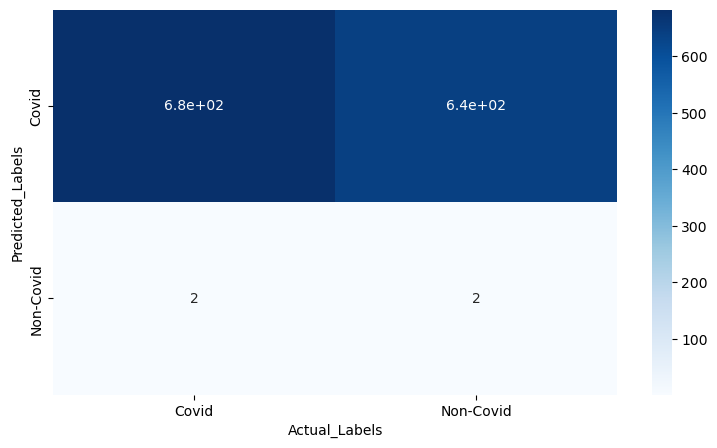

test accuracy = 51.50602409638554%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5151
Precision: 0.5078
Recall: 0.5151
F1 Score: 0.3529


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,X_test_combined,y_test_combined)

In [ ]:
FL_DeepCovid_model.save('gsm_noniid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 6s 688ms/step


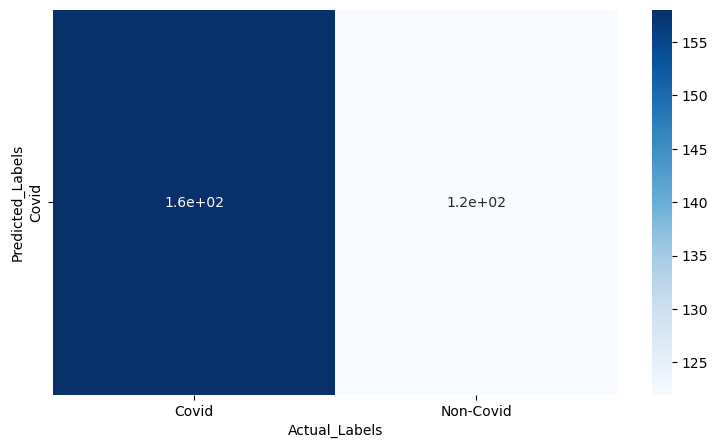

test accuracy = 56.42857142857143%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5643
Precision: 0.3184
Recall: 0.5643
F1 Score: 0.4071
--------------------- Student Model Evaluation on Dataset2 ------------------------


/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 [==============================] - 17s 692ms/step


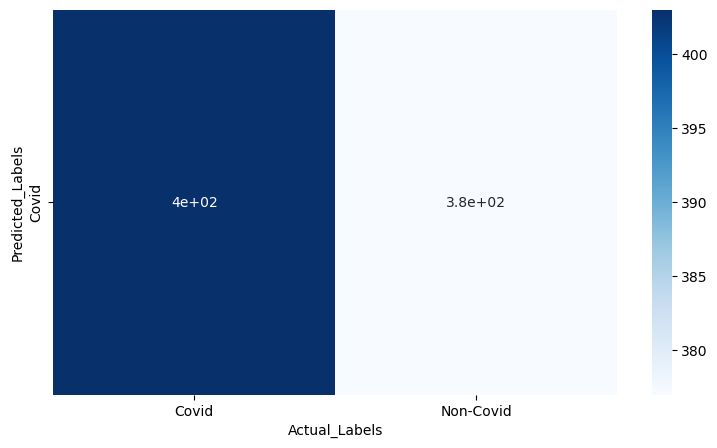

test accuracy = 51.66666666666667%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5167
Precision: 0.2669
Recall: 0.5167
F1 Score: 0.352
--------------------- Student Model Evaluation on Dataset3 ------------------------


/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 6s 662ms/step


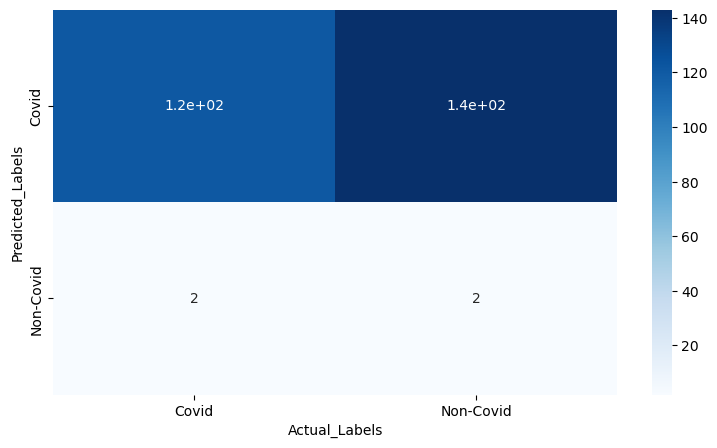

test accuracy = 45.8955223880597%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.459
Precision: 0.4809
Recall: 0.459
F1 Score: 0.3015


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset3_fed,test_labels_dataset3_fed)

### federated_train_data_nonIID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_balanced)
    FL_DeepCovid_model = evaluate(server_state,combined_test_data)
    loss = list(FL_DeepCovid_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_DeepCovid_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 33s 441ms/step - loss: 1.1882 - categorical_accuracy: 0.4646


  2%|▊                                        | 1/50 [02:20<1:54:22, 140.06s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1850 - categorical_accuracy: 0.4684


  4%|█▋                                       | 2/50 [04:39<1:51:40, 139.59s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1821 - categorical_accuracy: 0.4661


  6%|██▍                                      | 3/50 [07:53<2:09:02, 164.74s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1791 - categorical_accuracy: 0.4676


  8%|███▎                                     | 4/50 [10:13<1:58:33, 154.65s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1764 - categorical_accuracy: 0.4782


 10%|████                                     | 5/50 [12:35<1:52:41, 150.26s/it]

67/67 [==============================] - 34s 450ms/step - loss: 1.1749 - categorical_accuracy: 0.4789


 12%|████▉                                    | 6/50 [15:51<2:01:35, 165.80s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1741 - categorical_accuracy: 0.4992


 14%|█████▋                                   | 7/50 [19:06<2:05:37, 175.29s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1740 - categorical_accuracy: 0.4992


 16%|██████▌                                  | 8/50 [21:24<1:54:30, 163.59s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1746 - categorical_accuracy: 0.5000


 18%|███████▍                                 | 9/50 [23:44<1:46:35, 155.99s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1754 - categorical_accuracy: 0.5023


 20%|████████                                | 10/50 [26:07<1:41:16, 151.91s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1765 - categorical_accuracy: 0.5060


 22%|████████▊                               | 11/50 [28:26<1:36:21, 148.25s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1779 - categorical_accuracy: 0.5068


 24%|█████████▌                              | 12/50 [31:41<1:42:50, 162.38s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1792 - categorical_accuracy: 0.5083


 26%|██████████▍                             | 13/50 [34:00<1:35:48, 155.36s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1809 - categorical_accuracy: 0.5113


 28%|███████████▏                            | 14/50 [36:20<1:30:20, 150.56s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1822 - categorical_accuracy: 0.5090


 30%|████████████                            | 15/50 [39:38<1:36:09, 164.85s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1835 - categorical_accuracy: 0.5105


 32%|████████████▊                           | 16/50 [42:53<1:38:34, 173.96s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1848 - categorical_accuracy: 0.5120


 34%|█████████████▌                          | 17/50 [46:08<1:39:10, 180.33s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1857 - categorical_accuracy: 0.5136


 36%|██████████████▍                         | 18/50 [49:23<1:38:31, 184.73s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1861 - categorical_accuracy: 0.5120


 38%|███████████████▏                        | 19/50 [52:38<1:37:01, 187.78s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1869 - categorical_accuracy: 0.5120


 40%|████████████████                        | 20/50 [55:56<1:35:27, 190.93s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1874 - categorical_accuracy: 0.5105


 42%|████████████████▊                       | 21/50 [58:16<1:24:50, 175.53s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1876 - categorical_accuracy: 0.5120


 44%|████████████████▋                     | 22/50 [1:00:35<1:16:51, 164.69s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1879 - categorical_accuracy: 0.5120


 46%|█████████████████▍                    | 23/50 [1:02:55<1:10:41, 157.10s/it]

67/67 [==============================] - 36s 442ms/step - loss: 1.1884 - categorical_accuracy: 0.5113


 48%|██████████████████▏                   | 24/50 [1:05:17<1:06:09, 152.67s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1883 - categorical_accuracy: 0.5136


 50%|███████████████████                   | 25/50 [1:07:37<1:02:01, 148.87s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1880 - categorical_accuracy: 0.5143


 52%|████████████████████▊                   | 26/50 [1:09:56<58:24, 146.01s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1879 - categorical_accuracy: 0.5143


 54%|█████████████████████▌                  | 27/50 [1:12:15<55:09, 143.89s/it]

67/67 [==============================] - 33s 450ms/step - loss: 1.1880 - categorical_accuracy: 0.5136


 56%|██████████████████████▍                 | 28/50 [1:14:36<52:24, 142.92s/it]

67/67 [==============================] - 37s 448ms/step - loss: 1.1878 - categorical_accuracy: 0.5136


 58%|███████████████████████▏                | 29/50 [1:17:55<55:54, 159.74s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1880 - categorical_accuracy: 0.5136


 60%|████████████████████████                | 30/50 [1:21:10<56:49, 170.47s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1890 - categorical_accuracy: 0.5151


 62%|████████████████████████▊               | 31/50 [1:24:25<56:17, 177.77s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1897 - categorical_accuracy: 0.5158


 64%|█████████████████████████▌              | 32/50 [1:27:40<54:51, 182.85s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1906 - categorical_accuracy: 0.5143


 66%|██████████████████████████▍             | 33/50 [1:29:59<48:06, 169.81s/it]

67/67 [==============================] - 36s 440ms/step - loss: 1.1917 - categorical_accuracy: 0.5143


 68%|███████████████████████████▏            | 34/50 [1:33:18<47:33, 178.36s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1923 - categorical_accuracy: 0.5143


 70%|████████████████████████████            | 35/50 [1:36:33<45:50, 183.38s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1932 - categorical_accuracy: 0.5151


 72%|████████████████████████████▊           | 36/50 [1:39:47<43:34, 186.76s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1936 - categorical_accuracy: 0.5151


 74%|█████████████████████████████▌          | 37/50 [1:42:07<37:22, 172.50s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1934 - categorical_accuracy: 0.5151


 76%|██████████████████████████████▍         | 38/50 [1:45:22<35:50, 179.24s/it]

67/67 [==============================] - 36s 440ms/step - loss: 1.1931 - categorical_accuracy: 0.5151


 78%|███████████████████████████████▏        | 39/50 [1:47:44<30:50, 168.22s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1931 - categorical_accuracy: 0.5151


 80%|████████████████████████████████        | 40/50 [1:50:04<26:36, 159.61s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1929 - categorical_accuracy: 0.5151


 82%|████████████████████████████████▊       | 41/50 [1:52:23<23:01, 153.53s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1924 - categorical_accuracy: 0.5151


 84%|█████████████████████████████████▌      | 42/50 [1:54:42<19:53, 149.24s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1917 - categorical_accuracy: 0.5151


 86%|██████████████████████████████████▍     | 43/50 [1:57:57<19:00, 162.87s/it]

67/67 [==============================] - 36s 441ms/step - loss: 1.1910 - categorical_accuracy: 0.5151


 88%|███████████████████████████████████▏    | 44/50 [2:00:19<15:39, 156.64s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1908 - categorical_accuracy: 0.5143


 90%|████████████████████████████████████    | 45/50 [2:02:39<12:38, 151.60s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1903 - categorical_accuracy: 0.5143


 92%|████████████████████████████████████▊   | 46/50 [2:04:58<09:51, 147.96s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1906 - categorical_accuracy: 0.5136


 94%|█████████████████████████████████████▌  | 47/50 [2:08:13<08:06, 162.00s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1906 - categorical_accuracy: 0.5143


 96%|██████████████████████████████████████▍ | 48/50 [2:10:32<05:10, 155.19s/it]

67/67 [==============================] - 36s 445ms/step - loss: 1.1904 - categorical_accuracy: 0.5143


 98%|███████████████████████████████████████▏| 49/50 [2:12:55<02:31, 151.49s/it]

67/67 [==============================] - 34s 449ms/step - loss: 1.1903 - categorical_accuracy: 0.5136


100%|████████████████████████████████████████| 50/50 [2:15:17<00:00, 162.35s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 33s 717ms/step


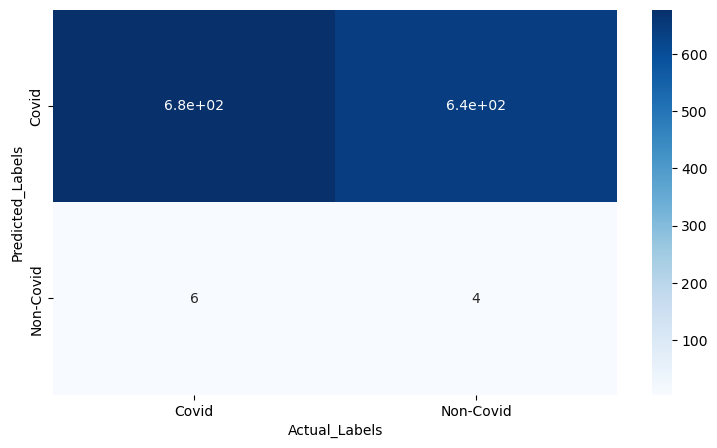

test accuracy = 51.35542168674698%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5136
Precision: 0.4589
Recall: 0.5136
F1 Score: 0.3548


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,X_test_combined,y_test_combined)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 6s 706ms/step


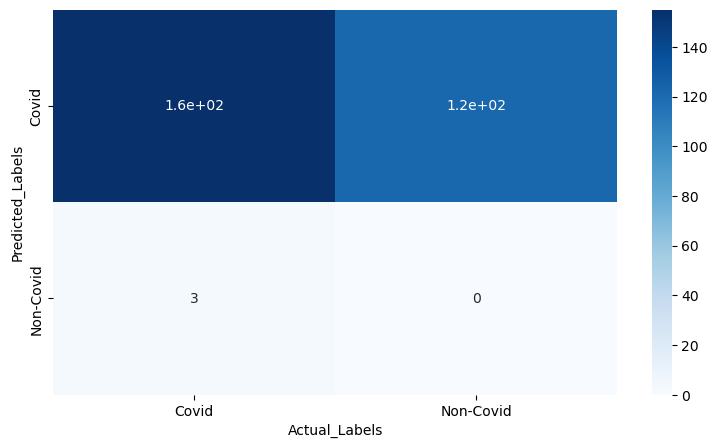

test accuracy = 55.35714285714286%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5536
Precision: 0.3158
Recall: 0.5536
F1 Score: 0.4021
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 18s 707ms/step


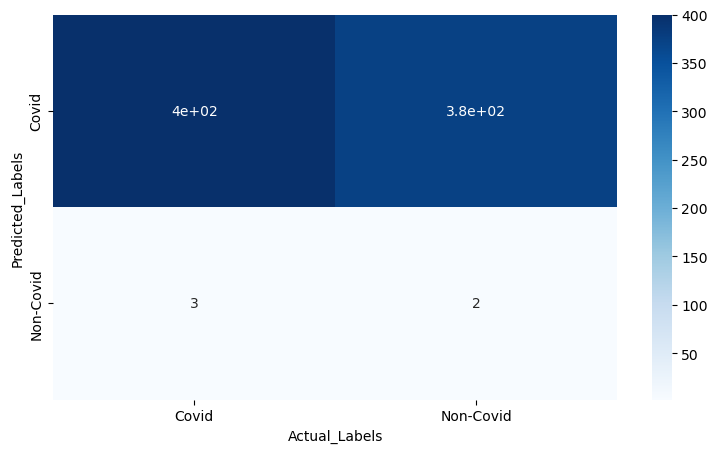

test accuracy = 51.53846153846153%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5154
Precision: 0.46
Recall: 0.5154
F1 Score: 0.3559
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 6s 674ms/step


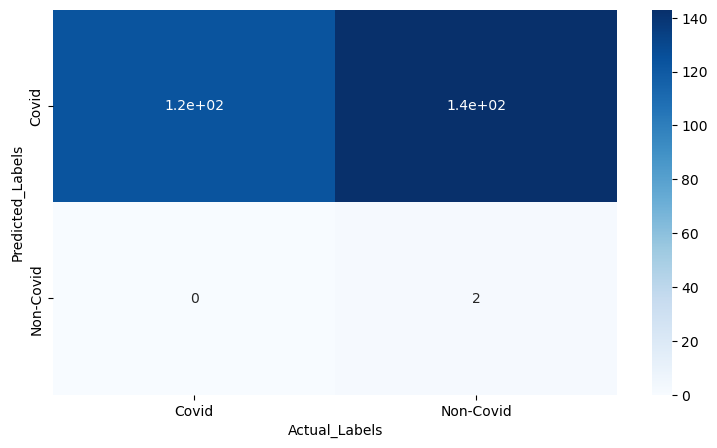

test accuracy = 46.64179104477612%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4664
Precision: 0.7533
Recall: 0.4664
F1 Score: 0.305


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
FL_DeepCovid_model.save('gsm_noniid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_unbalanced

In [ ]:
X_test_combined_iid = np.concatenate((test_features_dataset1_fed_iid, test_features_dataset2_fed_iid,
                                  test_features_dataset3_fed_iid), axis=0)
y_test_combined_iid = np.concatenate((test_labels_dataset1_fed_iid, test_labels_dataset2_fed_iid,
                                  test_labels_dataset3_fed_iid), axis=0)
test_data_iid = [(X_test_combined_iid,y_test_combined_iid )]
test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
# test_data_iid = [(X_test_combined_iid,y_test_combined_iid)]
# test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
# combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
# combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_unbalanced)
    FL_DeepCovid_model = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_DeepCovid_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_DeepCovid_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 33s 441ms/step - loss: 1.2179 - categorical_accuracy: 0.4179


  2%|▊                                        | 1/50 [03:17<2:41:10, 197.36s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.2115 - categorical_accuracy: 0.4209


  4%|█▋                                       | 2/50 [06:32<2:36:59, 196.24s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.2044 - categorical_accuracy: 0.4119


  6%|██▍                                      | 3/50 [09:48<2:33:37, 196.12s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1983 - categorical_accuracy: 0.4104


  8%|███▎                                     | 4/50 [13:08<2:31:22, 197.45s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1932 - categorical_accuracy: 0.4247


 10%|████                                     | 5/50 [16:27<2:28:37, 198.16s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1882 - categorical_accuracy: 0.4330


 12%|████▉                                    | 6/50 [19:46<2:25:32, 198.46s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1841 - categorical_accuracy: 0.4345


 14%|█████▋                                   | 7/50 [23:02<2:21:41, 197.71s/it]

67/67 [==============================] - 36s 439ms/step - loss: 1.1819 - categorical_accuracy: 0.4616


 16%|██████▌                                  | 8/50 [26:22<2:18:44, 198.20s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1807 - categorical_accuracy: 0.4864


 18%|███████▍                                 | 9/50 [29:37<2:14:50, 197.34s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1803 - categorical_accuracy: 0.4947


 20%|████████                                | 10/50 [32:53<2:11:13, 196.84s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1805 - categorical_accuracy: 0.5136


 22%|████████▊                               | 11/50 [36:09<2:07:47, 196.60s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1809 - categorical_accuracy: 0.5181


 24%|█████████▌                              | 12/50 [39:25<2:04:29, 196.56s/it]

67/67 [==============================] - 36s 442ms/step - loss: 1.1810 - categorical_accuracy: 0.5211


 26%|██████████▍                             | 13/50 [42:45<2:01:43, 197.38s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1810 - categorical_accuracy: 0.5226


 28%|███████████▏                            | 14/50 [46:04<1:58:48, 198.02s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1811 - categorical_accuracy: 0.5256


 30%|████████████                            | 15/50 [49:24<1:55:49, 198.55s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1810 - categorical_accuracy: 0.5279


 32%|████████████▊                           | 16/50 [52:43<1:52:40, 198.83s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1812 - categorical_accuracy: 0.5286


 34%|█████████████▌                          | 17/50 [56:03<1:49:24, 198.94s/it]

67/67 [==============================] - 37s 451ms/step - loss: 1.1814 - categorical_accuracy: 0.5279


 36%|██████████████▍                         | 18/50 [59:25<1:46:36, 199.89s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1812 - categorical_accuracy: 0.5279


 38%|██████████████▍                       | 19/50 [1:02:44<1:43:08, 199.62s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1807 - categorical_accuracy: 0.5286


 40%|███████████████▏                      | 20/50 [1:06:01<1:39:25, 198.85s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1799 - categorical_accuracy: 0.5294


 42%|███████████████▉                      | 21/50 [1:09:16<1:35:38, 197.89s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1793 - categorical_accuracy: 0.5279


 44%|████████████████▋                     | 22/50 [1:12:32<1:32:04, 197.30s/it]

67/67 [==============================] - 36s 440ms/step - loss: 1.1785 - categorical_accuracy: 0.5256


 46%|█████████████████▍                    | 23/50 [1:15:52<1:29:03, 197.90s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1779 - categorical_accuracy: 0.5226


 48%|██████████████████▏                   | 24/50 [1:19:08<1:25:35, 197.52s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1773 - categorical_accuracy: 0.5226


 50%|███████████████████                   | 25/50 [1:22:24<1:22:06, 197.08s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1771 - categorical_accuracy: 0.5226


 52%|███████████████████▊                  | 26/50 [1:25:39<1:18:36, 196.51s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1770 - categorical_accuracy: 0.5226


 54%|████████████████████▌                 | 27/50 [1:28:56<1:15:18, 196.45s/it]

67/67 [==============================] - 36s 440ms/step - loss: 1.1771 - categorical_accuracy: 0.5241


 56%|█████████████████████▎                | 28/50 [1:32:16<1:12:24, 197.46s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1770 - categorical_accuracy: 0.5248


 58%|██████████████████████                | 29/50 [1:35:32<1:08:59, 197.11s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1769 - categorical_accuracy: 0.5264


 60%|██████████████████████▊               | 30/50 [1:38:51<1:05:56, 197.83s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1770 - categorical_accuracy: 0.5271


 62%|███████████████████████▌              | 31/50 [1:42:08<1:02:29, 197.36s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1770 - categorical_accuracy: 0.5271


 64%|█████████████████████████▌              | 32/50 [1:45:23<59:03, 196.85s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1771 - categorical_accuracy: 0.5271


 66%|██████████████████████████▍             | 33/50 [1:48:46<56:15, 198.54s/it]

67/67 [==============================] - 33s 443ms/step - loss: 1.1771 - categorical_accuracy: 0.5279


 68%|███████████████████████████▏            | 34/50 [1:52:02<52:43, 197.75s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1770 - categorical_accuracy: 0.5271


 70%|████████████████████████████            | 35/50 [1:55:18<49:21, 197.40s/it]

67/67 [==============================] - 33s 447ms/step - loss: 1.1770 - categorical_accuracy: 0.5248


 72%|████████████████████████████▊           | 36/50 [1:58:39<46:17, 198.38s/it]

67/67 [==============================] - 33s 445ms/step - loss: 1.1768 - categorical_accuracy: 0.5233


 74%|█████████████████████████████▌          | 37/50 [2:01:57<42:57, 198.29s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1767 - categorical_accuracy: 0.5226


 76%|██████████████████████████████▍         | 38/50 [2:05:19<39:53, 199.43s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1767 - categorical_accuracy: 0.5218


 78%|███████████████████████████████▏        | 39/50 [2:08:35<36:21, 198.30s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1767 - categorical_accuracy: 0.5218


 80%|████████████████████████████████        | 40/50 [2:11:50<32:55, 197.52s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1771 - categorical_accuracy: 0.5196


 82%|████████████████████████████████▊       | 41/50 [2:15:06<29:31, 196.86s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1770 - categorical_accuracy: 0.5196


 84%|█████████████████████████████████▌      | 42/50 [2:18:21<26:11, 196.38s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1770 - categorical_accuracy: 0.5218


 86%|██████████████████████████████████▍     | 43/50 [2:21:40<22:59, 197.04s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1769 - categorical_accuracy: 0.5218


 88%|███████████████████████████████████▏    | 44/50 [2:24:56<19:40, 196.81s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1768 - categorical_accuracy: 0.5226


 90%|████████████████████████████████████    | 45/50 [2:28:12<16:22, 196.47s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1767 - categorical_accuracy: 0.5233


 92%|████████████████████████████████████▊   | 46/50 [2:31:26<13:03, 195.97s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1765 - categorical_accuracy: 0.5233


 94%|█████████████████████████████████████▌  | 47/50 [2:34:46<09:50, 197.00s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1764 - categorical_accuracy: 0.5241


 96%|██████████████████████████████████████▍ | 48/50 [2:38:05<06:35, 197.58s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1765 - categorical_accuracy: 0.5241


 98%|███████████████████████████████████████▏| 49/50 [2:41:24<03:18, 198.15s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1768 - categorical_accuracy: 0.5241


100%|████████████████████████████████████████| 50/50 [2:44:43<00:00, 197.68s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 33s 704ms/step


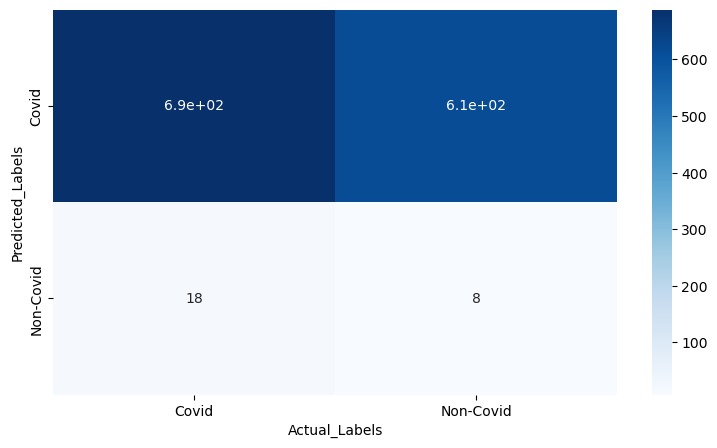

test accuracy = 52.40963855421686%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5241
Precision: 0.425
Recall: 0.5241
F1 Score: 0.3759


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 6s 694ms/step


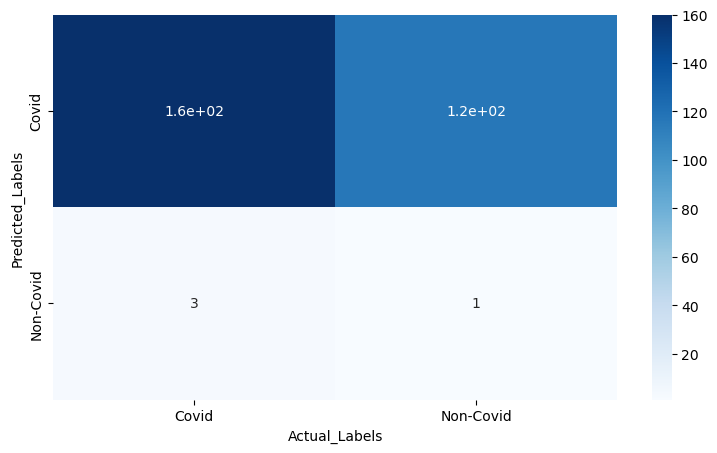

test accuracy = 57.49999999999999%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.575
Precision: 0.4419
Recall: 0.575
F1 Score: 0.4312
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 17s 694ms/step


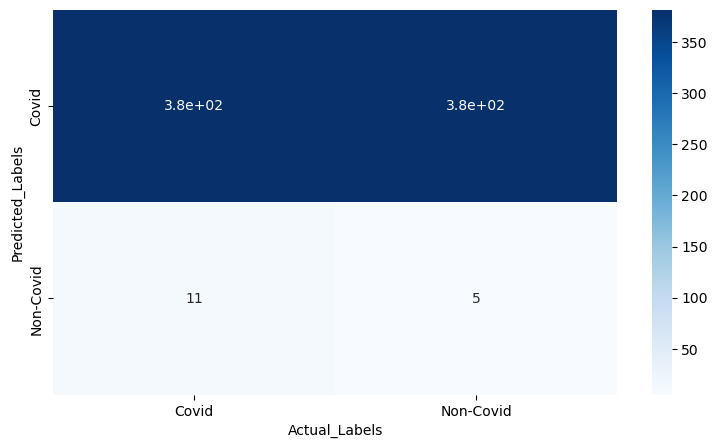

test accuracy = 49.61538461538461%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4962
Precision: 0.407
Recall: 0.4962
F1 Score: 0.345
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 6s 660ms/step


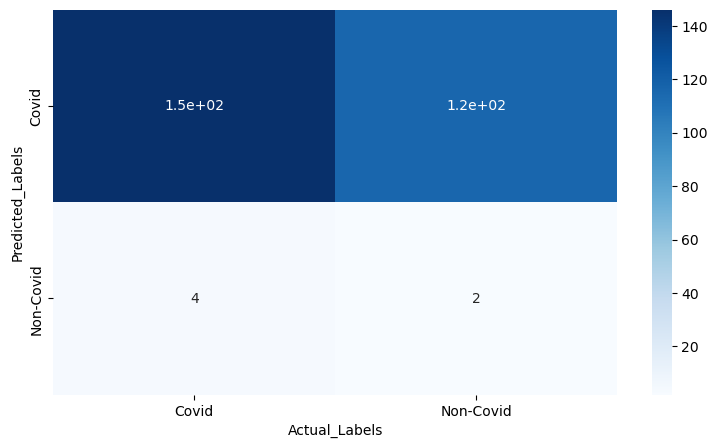

test accuracy = 55.223880597014926%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5522
Precision: 0.4587
Recall: 0.5522
F1 Score: 0.4109


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_DeepCovid_model.save('gsm_iid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_balanced)
    FL_DeepCovid_model = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_DeepCovid_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_DeepCovid_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 33s 439ms/step - loss: 1.2175 - categorical_accuracy: 0.4247


  2%|▊                                        | 1/50 [03:15<2:39:17, 195.05s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.2110 - categorical_accuracy: 0.4217


  4%|█▋                                       | 2/50 [05:37<2:11:05, 163.87s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.2033 - categorical_accuracy: 0.4285


  6%|██▍                                      | 3/50 [07:56<1:59:41, 152.79s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1950 - categorical_accuracy: 0.4194


  8%|███▎                                     | 4/50 [10:15<1:52:57, 147.34s/it]

67/67 [==============================] - 33s 447ms/step - loss: 1.1890 - categorical_accuracy: 0.4300


 10%|████                                     | 5/50 [13:31<2:03:31, 164.70s/it]

67/67 [==============================] - 33s 437ms/step - loss: 1.1837 - categorical_accuracy: 0.4480


 12%|████▉                                    | 6/50 [16:45<2:08:16, 174.92s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1800 - categorical_accuracy: 0.4450


 14%|█████▋                                   | 7/50 [19:08<1:57:44, 164.30s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1771 - categorical_accuracy: 0.4646


 16%|██████▌                                  | 8/50 [22:23<2:01:51, 174.08s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1759 - categorical_accuracy: 0.4774


 18%|███████▍                                 | 9/50 [24:42<1:51:31, 163.22s/it]

67/67 [==============================] - 33s 437ms/step - loss: 1.1755 - categorical_accuracy: 0.4955


 20%|████████                                | 10/50 [27:57<1:55:19, 172.99s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1752 - categorical_accuracy: 0.5053


 22%|████████▊                               | 11/50 [31:11<1:56:42, 179.54s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1756 - categorical_accuracy: 0.5105


 24%|█████████▌                              | 12/50 [34:30<1:57:17, 185.20s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1758 - categorical_accuracy: 0.5188


 26%|██████████▍                             | 13/50 [36:49<1:45:36, 171.27s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1763 - categorical_accuracy: 0.5181


 28%|███████████▏                            | 14/50 [39:09<1:37:03, 161.75s/it]

67/67 [==============================] - 33s 437ms/step - loss: 1.1770 - categorical_accuracy: 0.5151


 30%|████████████                            | 15/50 [42:23<1:40:09, 171.70s/it]

67/67 [==============================] - 36s 440ms/step - loss: 1.1777 - categorical_accuracy: 0.5151


 32%|████████████▊                           | 16/50 [45:41<1:41:43, 179.52s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1781 - categorical_accuracy: 0.5143


 34%|█████████████▌                          | 17/50 [48:56<1:41:20, 184.26s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1782 - categorical_accuracy: 0.5128


 36%|██████████████▍                         | 18/50 [52:11<1:40:00, 187.50s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1782 - categorical_accuracy: 0.5120


 38%|███████████████▏                        | 19/50 [55:26<1:37:59, 189.67s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1782 - categorical_accuracy: 0.5166


 40%|████████████████                        | 20/50 [58:41<1:35:34, 191.14s/it]

67/67 [==============================] - 36s 440ms/step - loss: 1.1783 - categorical_accuracy: 0.5181


 42%|███████████████▉                      | 21/50 [1:01:03<1:25:15, 176.41s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1780 - categorical_accuracy: 0.5188


 44%|████████████████▋                     | 22/50 [1:04:18<1:24:56, 182.03s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1779 - categorical_accuracy: 0.5181


 46%|█████████████████▍                    | 23/50 [1:07:33<1:23:37, 185.85s/it]

67/67 [==============================] - 33s 448ms/step - loss: 1.1779 - categorical_accuracy: 0.5188


 48%|██████████████████▏                   | 24/50 [1:10:48<1:21:44, 188.63s/it]

67/67 [==============================] - 33s 447ms/step - loss: 1.1778 - categorical_accuracy: 0.5173


 50%|███████████████████                   | 25/50 [1:13:09<1:12:36, 174.28s/it]

67/67 [==============================] - 36s 438ms/step - loss: 1.1779 - categorical_accuracy: 0.5181


 52%|███████████████████▊                  | 26/50 [1:16:27<1:12:33, 181.41s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1780 - categorical_accuracy: 0.5188


 54%|████████████████████▌                 | 27/50 [1:18:46<1:04:44, 168.88s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1779 - categorical_accuracy: 0.5173


 56%|█████████████████████▎                | 28/50 [1:22:01<1:04:47, 176.70s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1780 - categorical_accuracy: 0.5151


 58%|██████████████████████                | 29/50 [1:25:17<1:03:48, 182.33s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1782 - categorical_accuracy: 0.5120


 60%|██████████████████████▊               | 30/50 [1:28:31<1:02:01, 186.09s/it]

67/67 [==============================] - 36s 441ms/step - loss: 1.1785 - categorical_accuracy: 0.5105


 62%|████████████████████████▊               | 31/50 [1:30:54<54:48, 173.10s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1788 - categorical_accuracy: 0.5098


 64%|█████████████████████████▌              | 32/50 [1:34:09<53:52, 179.60s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1790 - categorical_accuracy: 0.5060


 66%|██████████████████████████▍             | 33/50 [1:37:24<52:12, 184.28s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1791 - categorical_accuracy: 0.5045


 68%|███████████████████████████▏            | 34/50 [1:39:44<45:32, 170.79s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1794 - categorical_accuracy: 0.5045


 70%|████████████████████████████            | 35/50 [1:42:03<40:20, 161.37s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1796 - categorical_accuracy: 0.5060


 72%|████████████████████████████▊           | 36/50 [1:44:25<36:19, 155.69s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1798 - categorical_accuracy: 0.5075


 74%|█████████████████████████████▌          | 37/50 [1:46:45<32:40, 150.84s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1798 - categorical_accuracy: 0.5075


 76%|██████████████████████████████▍         | 38/50 [1:49:04<29:28, 147.40s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1799 - categorical_accuracy: 0.5075


 78%|███████████████████████████████▏        | 39/50 [1:52:19<29:37, 161.60s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1800 - categorical_accuracy: 0.5090


 80%|████████████████████████████████        | 40/50 [1:54:38<25:48, 154.83s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1802 - categorical_accuracy: 0.5090


 82%|████████████████████████████████▊       | 41/50 [1:57:00<22:40, 151.11s/it]

67/67 [==============================] - 33s 442ms/step - loss: 1.1805 - categorical_accuracy: 0.5053


 84%|█████████████████████████████████▌      | 42/50 [2:00:16<21:55, 164.42s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1808 - categorical_accuracy: 0.5075


 86%|██████████████████████████████████▍     | 43/50 [2:02:35<18:17, 156.86s/it]

67/67 [==============================] - 33s 439ms/step - loss: 1.1811 - categorical_accuracy: 0.5075


 88%|███████████████████████████████████▏    | 44/50 [2:04:54<15:08, 151.40s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1813 - categorical_accuracy: 0.5083


 90%|████████████████████████████████████    | 45/50 [2:07:13<12:18, 147.76s/it]

67/67 [==============================] - 33s 441ms/step - loss: 1.1816 - categorical_accuracy: 0.5090


 92%|████████████████████████████████████▊   | 46/50 [2:09:36<09:44, 146.21s/it]

67/67 [==============================] - 34s 449ms/step - loss: 1.1818 - categorical_accuracy: 0.5120


 94%|█████████████████████████████████████▌  | 47/50 [2:11:56<07:13, 144.57s/it]

67/67 [==============================] - 34s 450ms/step - loss: 1.1818 - categorical_accuracy: 0.5136


 96%|██████████████████████████████████████▍ | 48/50 [2:15:12<05:19, 159.87s/it]

67/67 [==============================] - 33s 440ms/step - loss: 1.1821 - categorical_accuracy: 0.5120


 98%|███████████████████████████████████████▏| 49/50 [2:17:31<02:33, 153.65s/it]

67/67 [==============================] - 33s 438ms/step - loss: 1.1824 - categorical_accuracy: 0.5143


100%|████████████████████████████████████████| 50/50 [2:19:50<00:00, 167.81s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 36s 703ms/step


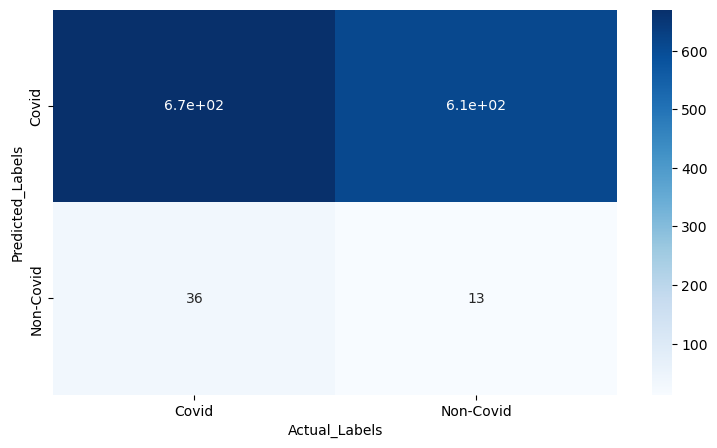

test accuracy = 51.43072289156626%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5143
Precision: 0.4028
Recall: 0.5143
F1 Score: 0.377


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 6s 706ms/step


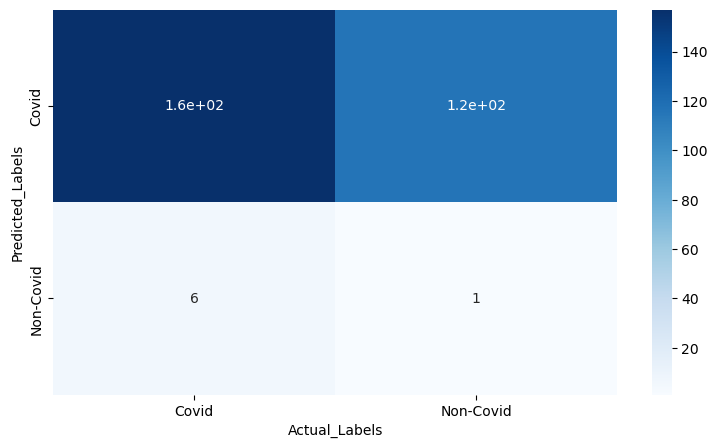

test accuracy = 56.42857142857143%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5643
Precision: 0.3945
Recall: 0.5643
F1 Score: 0.426
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 17s 695ms/step


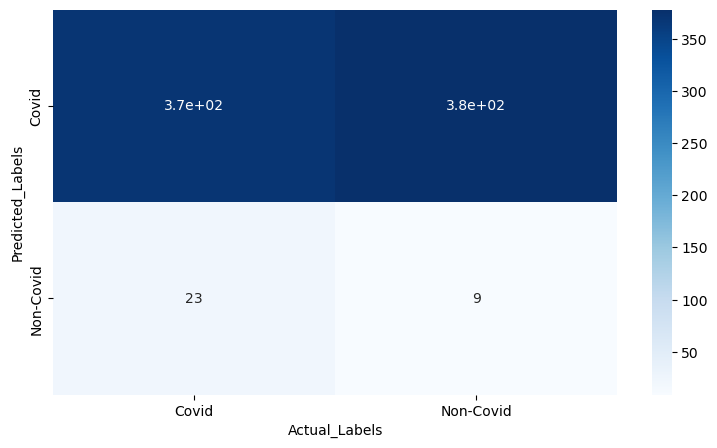

test accuracy = 48.58974358974359%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4859
Precision: 0.3888
Recall: 0.4859
F1 Score: 0.3481
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 6s 659ms/step


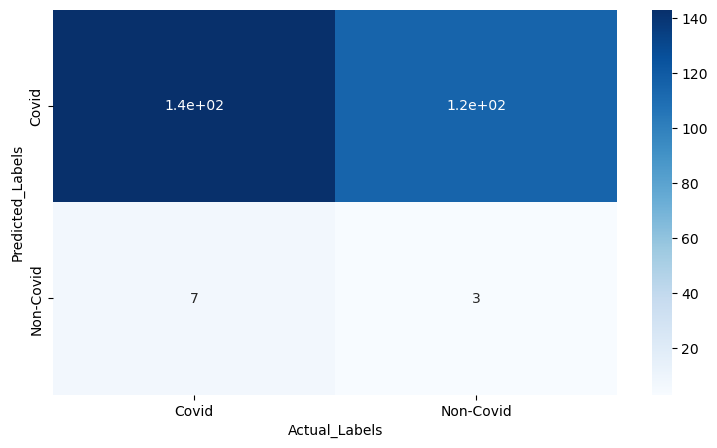

test accuracy = 54.47761194029851%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5448
Precision: 0.4423
Recall: 0.5448
F1 Score: 0.413


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_DeepCovid_model,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_DeepCovid_model.save('gsm_iid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
